## Preparation

In [ ]:
!pip install -q opencv-python

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount = False)

Mounted at /content/drive/


In [ ]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:

!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')


def detect(input_tensor, inference_count=3):

  image_height, image_width, channel = input_tensor.shape

  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)


  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(),
                            reset_crop_region=False)

  return person

Cloning into 'examples'...
remote: Enumerating objects: 23708, done.
remote: Counting objects: 100% (672/672), done.
remote: Compressing objects: 100% (412/412), done.
remote: Total 23708 (delta 218), reused 610 (delta 172), pack-reused 23036
Receiving objects: 100% (23708/23708), 44.18 MiB | 31.03 MiB/s, done.
Resolving deltas: 100% (12866/12866), done.


In [ ]:


def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):




  image_np = utils.visualize(image, [person])


  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)

  if close_figure:
    plt.close(fig)

  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

In [ ]:
class MoveNetPreprocessor(object):
  """Helper class to preprocess pose sample images for classification."""

  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_path):

    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []


    self._csvs_out_folder_per_class = tempfile.mkdtemp()


    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )

  def process(self, per_pose_class_limit=None, detection_threshold=0.1):

    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # Paths for the pose class.
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)

      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file,
                                    delimiter=',',
                                    quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted(
            [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0

        # Detect pose landmarks from each image
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape

          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path +
                                  '. Image isn\'t in RGB format.')
            continue
          person = detect(image)

          # Save landmarks if all landmarks were detected
          min_landmark_score = min(
              [keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path +
                                  '. No pose was confidentlly detected.')
            continue

          valid_image_count += 1

          # Draw the prediction result on top of the image for debugging later
          output_overlay = draw_prediction_on_image(
              image.numpy().astype(np.uint8), person,
              close_figure=True, keep_input_size=True)

          # Write detection result into an image file
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)

          # Get landmarks and scale it to the same size as the input image
          pose_landmarks = np.array(
              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                for keypoint in person.keypoints],
              dtype=np.float32)

          # Write the landmark coordinates to its per-class CSV file
          coordinates = pose_landmarks.flatten().astype(np.str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError(
              'No valid images found for the "{}" class.'
              .format(pose_class_name))

    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names

  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)

      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '')
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)

    list_name = [[bodypart.name + '_x', bodypart.name + '_y',
                  bodypart.name + '_score'] for bodypart in BodyPart]
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i]
                  for i in range(len(header_name))}

    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

In [ ]:
is_skip_step_1 = False

In [ ]:
use_custom_dataset = True

dataset_is_split = False

In [ ]:

import os
import random
import shutil

def split_into_train_test(images_origin, images_dest, test_split):

  _, dirs, _ = next(os.walk(images_origin))

  TRAIN_DIR = os.path.join(images_dest, 'train')
  TEST_DIR = os.path.join(images_dest, 'test')
  os.makedirs(TRAIN_DIR, exist_ok=True)
  os.makedirs(TEST_DIR, exist_ok=True)

  for dir in dirs:
    # Get all filenames for this dir, filtered by filetype
    filenames = os.listdir(os.path.join(images_origin, dir))
    filenames = [os.path.join(images_origin, dir, f) for f in filenames if (
        f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.bmp'))]
    # Shuffle the files, deterministically
    filenames.sort()
    random.seed(42)
    random.shuffle(filenames)
    # Divide them into train/test dirs
    os.makedirs(os.path.join(TEST_DIR, dir), exist_ok=True)
    os.makedirs(os.path.join(TRAIN_DIR, dir), exist_ok=True)
    test_count = int(len(filenames) * test_split)
    for i, file in enumerate(filenames):
      if i < test_count:
        destination = os.path.join(TEST_DIR, dir, os.path.split(file)[1])
      else:
        destination = os.path.join(TRAIN_DIR, dir, os.path.split(file)[1])
      shutil.copyfile(file, destination)
    print(f'Moved {test_count} of {len(filenames)} from class "{dir}" into test.')
  print(f'Your split dataset is in "{images_dest}"')

In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/legglance flick.zip', 'r') as zip_ref:
    zip_ref.extractall('final/')

In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Sweep.zip', 'r') as zip_ref:
    zip_ref.extractall('final/')

In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Pull shot.zip', 'r') as zip_ref:
    zip_ref.extractall('final/')

In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Drive.zip', 'r') as zip_ref:
    zip_ref.extractall('final/')

In [ ]:
if use_custom_dataset:


  dataset_in = '/content/final'

  # You can leave the rest alone:
  if not os.path.isdir(dataset_in):
    raise Exception("dataset_in is not a valid directory")
  if dataset_is_split:
    IMAGES_ROOT = dataset_in
  else:
    dataset_out = 'split_' + dataset_in
    split_into_train_test(dataset_in, dataset_out, test_split=0.2)
    IMAGES_ROOT = dataset_out

Moved 176 of 884 from class "Drive" into test.
Moved 176 of 880 from class "Sweep" into test.
Moved 176 of 884 from class "legglance flick" into test.
Moved 175 of 877 from class "Pull shot" into test.
Your split dataset is in "split_/content/final"


### Preprocess the `TRAIN` dataset

In [ ]:

  images_in_train_folder = os.path.join(IMAGES_ROOT, 'train')
  images_out_train_folder = 'poses_images_out_train'
  csvs_out_train_path = 'train_data.csv'

  preprocessor = MoveNetPreprocessor(
      images_in_folder=images_in_train_folder,
      images_out_folder=images_out_train_folder,
      csvs_out_path=csvs_out_train_path,
  )

  preprocessor.process(per_pose_class_limit=None)

Preprocessing Drive
  0%|          | 0/708 [00:00<?, ?it/s]<ipython-input-6-c4e95dcbb297>:98: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coordinates = pose_landmarks.flatten().astype(np.str).tolist()
 26%|██▌       | 184/708 [10:36<29:41,  3.40s/it]/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 708/708 [40:44<00:00,  3.45s/it]
Preprocessing Pull shot
100%|██████████| 702/702 [40:27<00:00,  3.4

Skipped split_/content/final/train/Drive/drives100.png. No pose was confidentlly detected.
Skipped split_/content/final/train/Drive/drives101.png. No pose was confidentlly detected.
Skipped split_/content/final/train/Drive/drives106.png. No pose was confidentlly detected.
Skipped split_/content/final/train/Drive/drives109.png. No pose was confidentlly detected.
Skipped split_/content/final/train/Drive/drives112.png. No pose was confidentlly detected.
Skipped split_/content/final/train/Drive/drives113.png. No pose was confidentlly detected.
Skipped split_/content/final/train/Drive/drives115.png. No pose was confidentlly detected.
Skipped split_/content/final/train/Drive/drives118.png. No pose was confidentlly detected.
Skipped split_/content/final/train/Drive/drives119.png. No pose was confidentlly detected.
Skipped split_/content/final/train/Drive/drives12.jpeg. No pose was confidentlly detected.
Skipped split_/content/final/train/Drive/drives123.png. No pose was confidentlly detected.

### Preprocess the `TEST` dataset

In [ ]:

  images_in_test_folder = os.path.join(IMAGES_ROOT, 'test')
  images_out_test_folder = 'poses_images_out_test'
  csvs_out_test_path = 'test_data.csv'

  preprocessor = MoveNetPreprocessor(
      images_in_folder=images_in_test_folder,
      images_out_folder=images_out_test_folder,
      csvs_out_path=csvs_out_test_path,
  )

  preprocessor.process(per_pose_class_limit=None)

Preprocessing Drive
  0%|          | 0/176 [00:00<?, ?it/s]<ipython-input-6-c4e95dcbb297>:98: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coordinates = pose_landmarks.flatten().astype(np.str).tolist()
 68%|██████▊   | 119/176 [06:54<03:15,  3.42s/it]/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 176/176 [10:11<00:00,  3.48s/it]
Preprocessing Pull shot
100%|██████████| 175/175 [10:11<00:00,  3.4

Skipped split_/content/final/test/Drive/drives124.png. No pose was confidentlly detected.
Skipped split_/content/final/test/Drive/drives125.png. No pose was confidentlly detected.
Skipped split_/content/final/test/Drive/drives129.png. No pose was confidentlly detected.
Skipped split_/content/final/test/Drive/drives131.png. No pose was confidentlly detected.
Skipped split_/content/final/test/Drive/drives144.png. No pose was confidentlly detected.
Skipped split_/content/final/test/Drive/drives154.png. No pose was confidentlly detected.
Skipped split_/content/final/test/Drive/drives256.png. No pose was confidentlly detected.
Skipped split_/content/final/test/Drive/drives278.png. No pose was confidentlly detected.
Skipped split_/content/final/test/Drive/drives279.png. No pose was confidentlly detected.
Skipped split_/content/final/test/Drive/drives28.png. No pose was confidentlly detected.
Skipped split_/content/final/test/Drive/drives280.png. No pose was confidentlly detected.
Skipped spl

In [ ]:
def load_pose_landmarks(csv_path):

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

In [ ]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15)

In [ ]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

In [ ]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center,
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

In [ ]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model=keras.Model(inputs, outputs)
model.summary()



#model = keras.Sequential([

    #keras.Input(shape=(784)),
    #layers.Dense(256, activation='softmax'),

    # dense layer 2
    #layers.Dense(128, activation='softmax'),

      # output layer
    #layers.Dense(10, activation='softmax'),
#])







Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 51)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 17, 3)                0         ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.getitem (  (None, 17, 2)                0         ['reshape[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.compat.v1.gather (TFOpL  (None, 2)                    0         ['tf.__operators__.getitem

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=40)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val))
                    #callbacks=[checkpoint, earlystopping])

Epoch 1/200
97/97 [==============================] - 4s 14ms/step - loss: 1.3284 - accuracy: 0.3379 - val_loss: 1.2360 - val_accuracy: 0.4301
Epoch 2/200
97/97 [==============================] - 1s 6ms/step - loss: 1.1666 - accuracy: 0.4925 - val_loss: 1.0266 - val_accuracy: 0.6728
Epoch 3/200
97/97 [==============================] - 1s 12ms/step - loss: 1.0192 - accuracy: 0.6023 - val_loss: 0.9117 - val_accuracy: 0.6912
Epoch 4/200
97/97 [==============================] - 0s 5ms/step - loss: 0.9180 - accuracy: 0.6524 - val_loss: 0.8120 - val_accuracy: 0.7316
Epoch 5/200
97/97 [==============================] - 0s 3ms/step - loss: 0.8453 - accuracy: 0.6738 - val_loss: 0.7394 - val_accuracy: 0.7721
Epoch 6/200
97/97 [==============================] - 0s 3ms/step - loss: 0.8016 - accuracy: 0.7018 - val_loss: 0.7118 - val_accuracy: 0.7647
Epoch 7/200
97/97 [==============================] - 0s 3ms/step - loss: 0.7817 - accuracy: 0.7083 - val_loss: 0.6669 - val_accuracy: 0.7794
Epoch 8/200

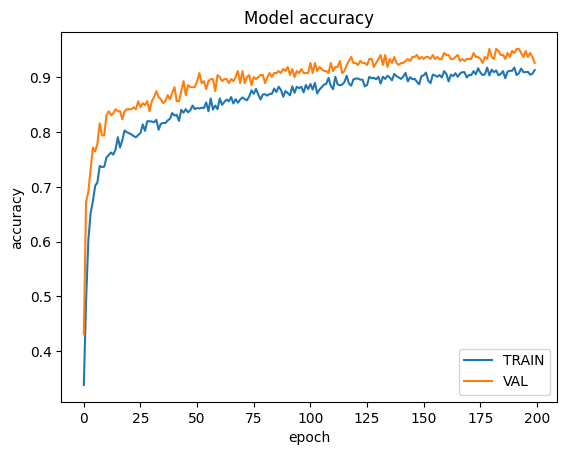

In [ ]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [ ]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

14/14 [==============================] - 0s 2ms/step - loss: 0.4172 - accuracy: 0.8476


### confusion matrix to better understand the model performance

14/14 [==============================] - 0s 2ms/step
Confusion matrix, without normalization

Classification Report:
                  precision    recall  f1-score   support

          Drive       0.74      0.85      0.79       100
      Pull shot       0.85      0.92      0.88        99
          Sweep       0.95      0.92      0.93       109
legglance flick       0.86      0.73      0.79       125

       accuracy                           0.85       433
      macro avg       0.85      0.85      0.85       433
   weighted avg       0.85      0.85      0.85       433



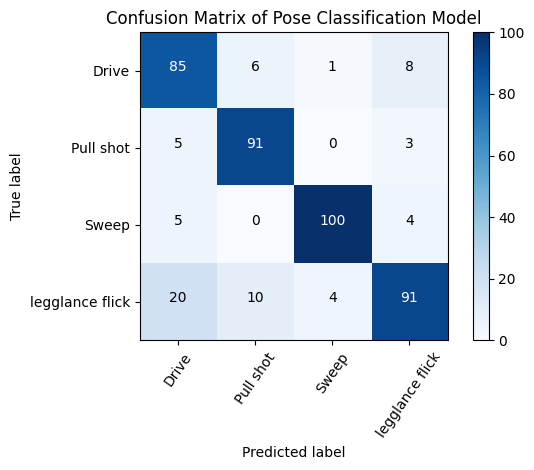

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))